#### Zero-shot reference mapping tutorial with scGPT

This file is modified by Rohan

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under `data` directory in the outer level.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y). 


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset    
 2. Generate scGPT embeddings for each cell in reference and query datasets
 3. Transfer the annotations from reference to query dataset

At the [appendix](#appendix-reference-mapping-on-lung-kim-dataset) of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).

We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.

In [1]:
from schelp.utils.config import load_config
from rich import print as rprint

paths = load_config(dataset_key="init")

rprint(paths)
data_dir = str(paths["data"]) + "/"
rprint(data_dir)

!tree -L 3 /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets

{
    'pretrained_models': 
PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/pretrained_models'),
    'data': PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets'),
    'package_dir': PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp'),
    'config_file': 
PosixPath('/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/schelp/config.toml')
}

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets/

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets
├── COVID-19-splitted
│   └── covid
│       ├── batch_covid_subsampled_test.h5ad
│       └── batch_covid_subsampled_train.h5ad
└── Lung-Kim-splitted
    └── lung
        ├── sample_proc_lung_test.h5ad
        └── sample_proc_lung_train.h5ad

5 directories, 4 files


In [2]:
# import os
# import sys
# import gdown

# data_dir = str(paths["scratch"]) + "/"
# print(data_dir)
# if not os.path.exists(data_dir):
#     os.mkdir(data_dir)
# if not os.path.exists(os.path.join(data_dir, "covid")):
#     gdown.download_folder(
#         "https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS",
#         output=os.path.join(data_dir),
#     )
# if not os.path.exists(os.path.join(data_dir, "lung")):
#     gdown.download_folder(
#         "https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO",
#         output=os.path.join(data_dir),
#     )

# # batch_covid_subsampled_test.h5ad and batch_covid_subsampled_train.h5ad were manually downloaded.
# model_dir =  str(paths["pretrained_models"] / "scGPT_human")

## Import scGPT and dependencies

In [3]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print("faiss not installed! We highly recommend installing it for fast similarity search.")
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/torc

We set the columns storing gene name columns, batch key and cell type key.

In [4]:
model_dir = str(paths["pretrained_models"] / "scGPT_human")
model_dir = Path(model_dir)

In [5]:
data_dir = str(paths["data"]) + "/"
adata = sc.read_h5ad(data_dir + "COVID-19-splitted/covid/batch_covid_subsampled_train.h5ad")
test_adata = sc.read_h5ad(data_dir + "COVID-19-splitted/covid/batch_covid_subsampled_test.h5ad")

cell_type_key = "celltype"
gene_col = "gene_name"

Embed the reference dataset

In [6]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells:  98%|█████████▊| 246/250 [00:34<00:00, 49.84it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
  File 

Embed the query dataset

In [7]:
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells:  98%|█████████▊| 62/63 [00:04<00:00, 44.93it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multipro

In [8]:
rprint(adata.shape)
rprint(test_adata.shape)

(15997, 1200)

(4003, 1200)

Mark the reference vs. query cells and mask the cell types on query cells

In [9]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(ref_embed_adata)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/4201321170.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/4201321170.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df

## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

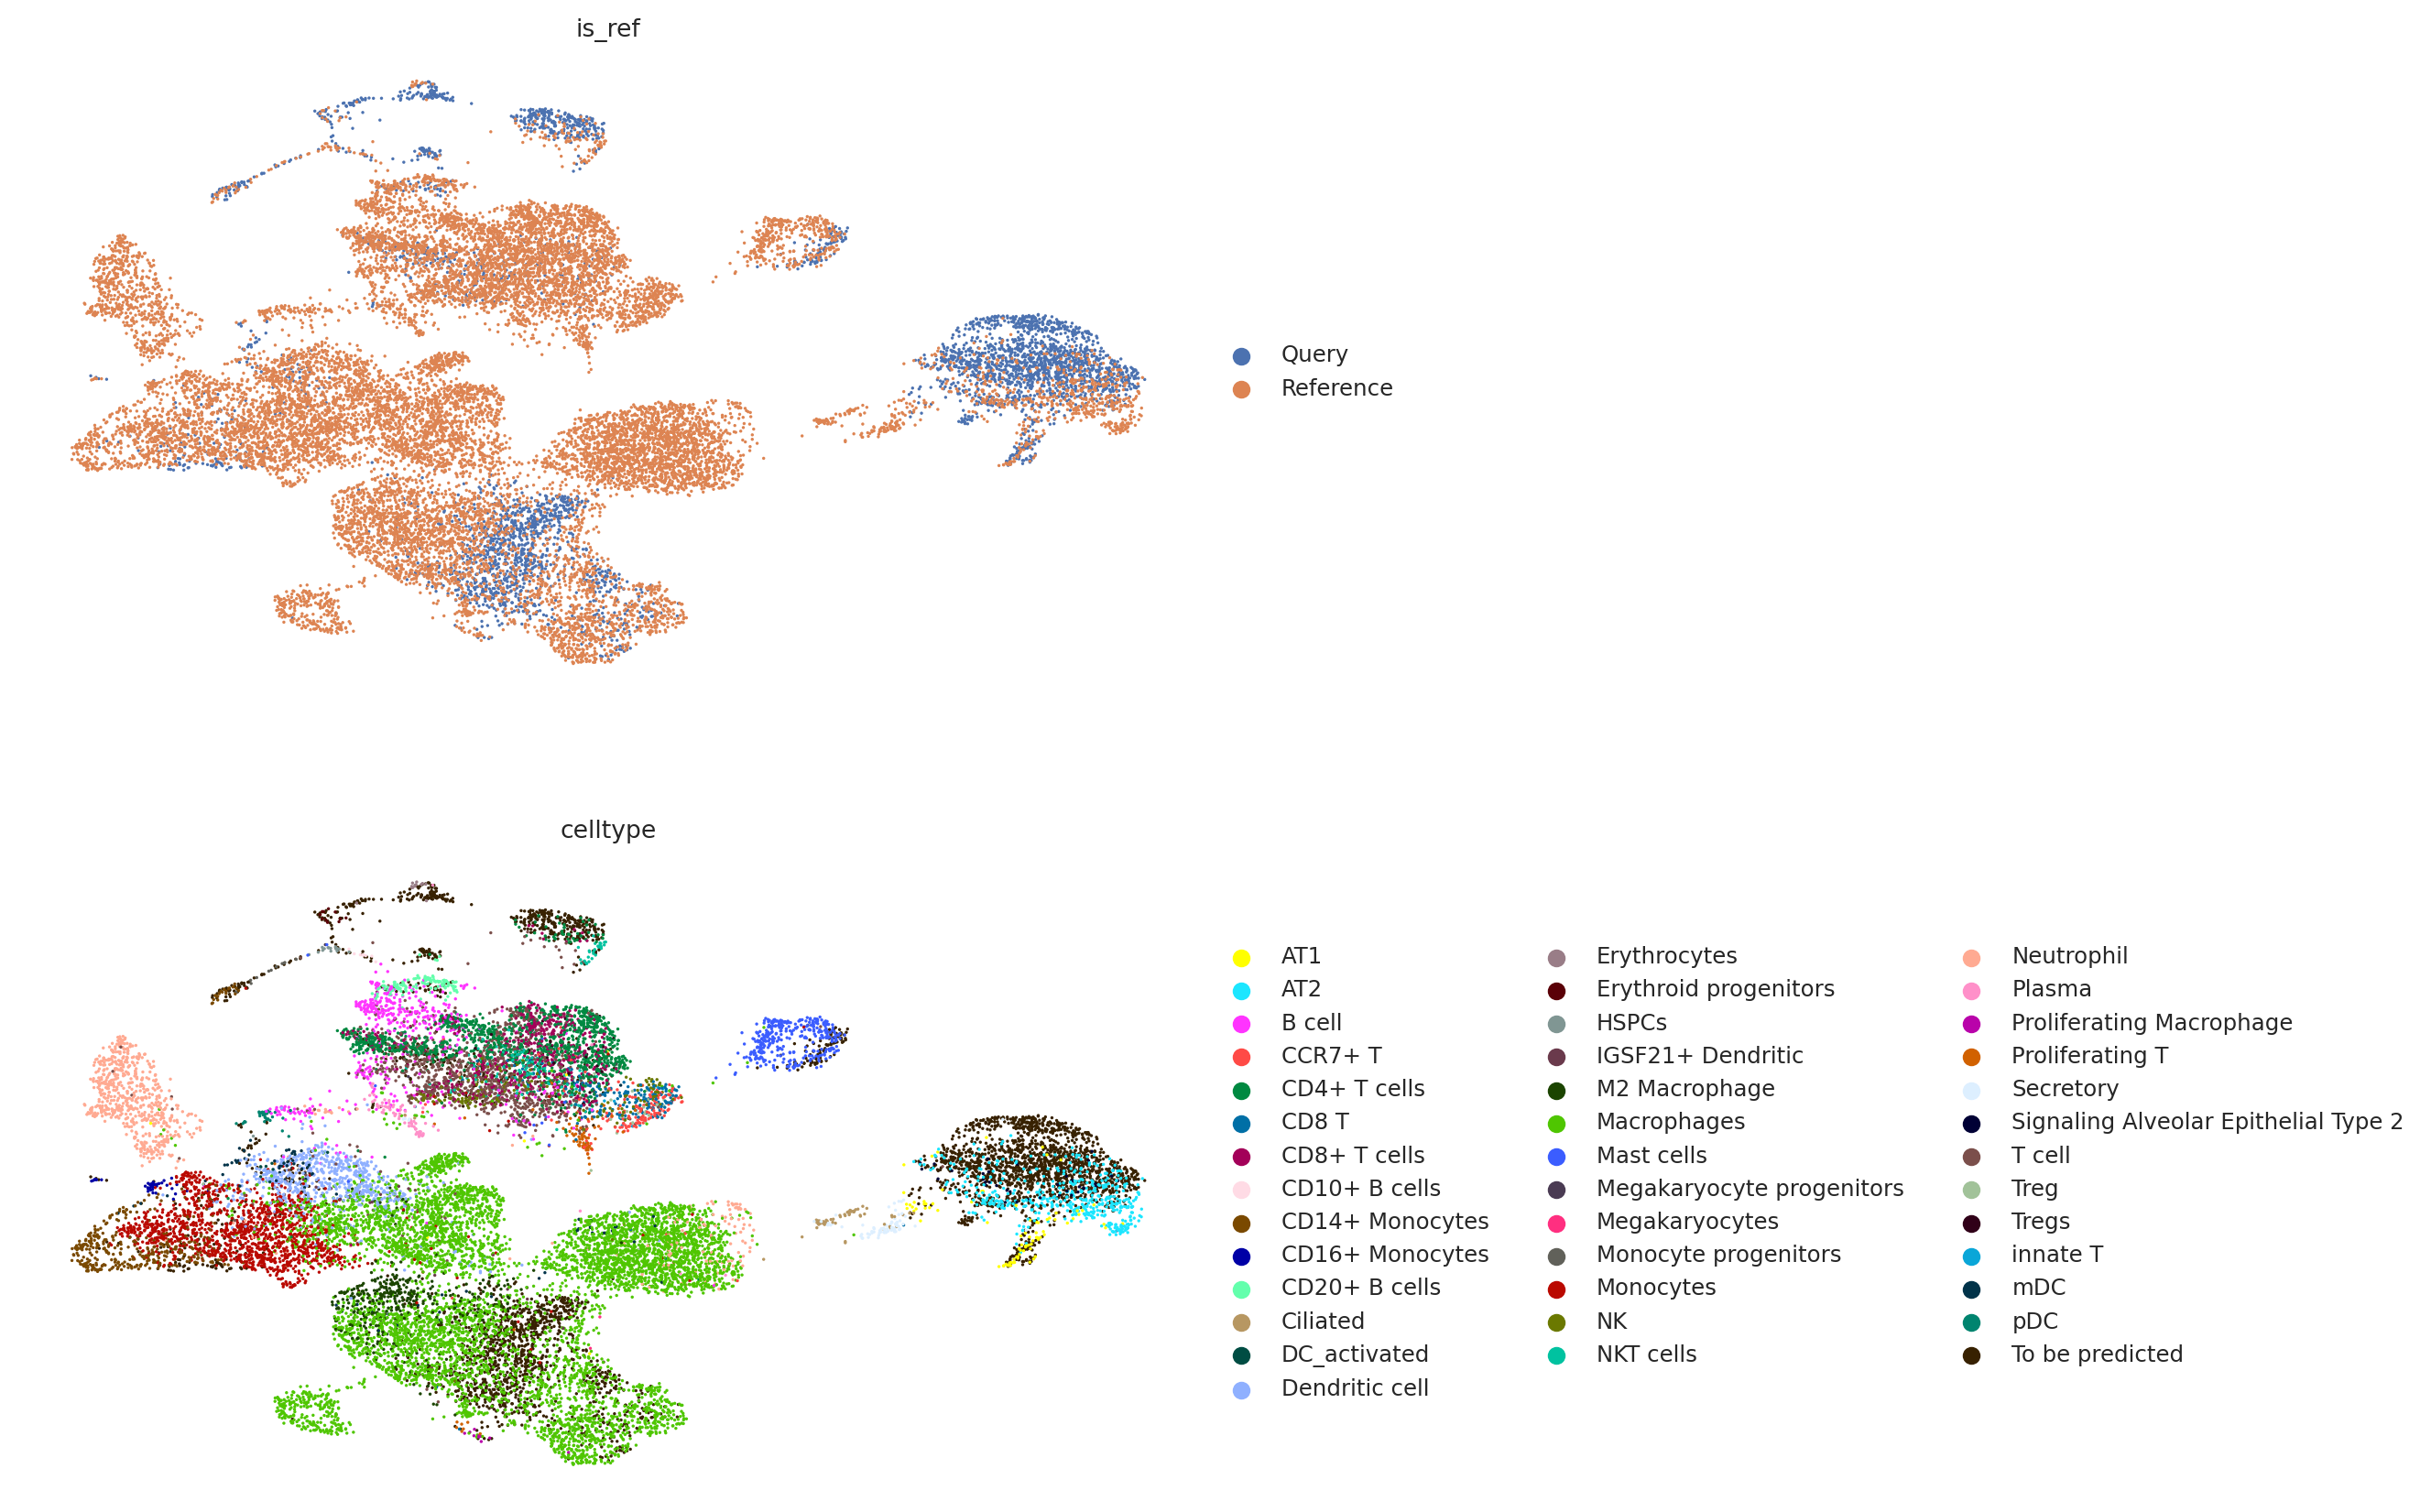

In [10]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1)

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [11]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims


def get_similar_vectors(vector, ref, top_k=10):
    # sims = cos_sim(vector, ref)
    sims = l2_sim(vector, ref)

    top_k_idx = np.argsort(sims)[::-1][:top_k]
    return top_k_idx, sims[top_k_idx]

In [12]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list = [i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/3100155394.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/3100155394.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/3100155394.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer 

## Evaluate the performance

In [13]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.8750936797401948,
 'precision': 0.5320248700192963,
 'recall': 0.4807477949042274,
 'macro_f1': 0.4701869744194286}

Confusion matrix:

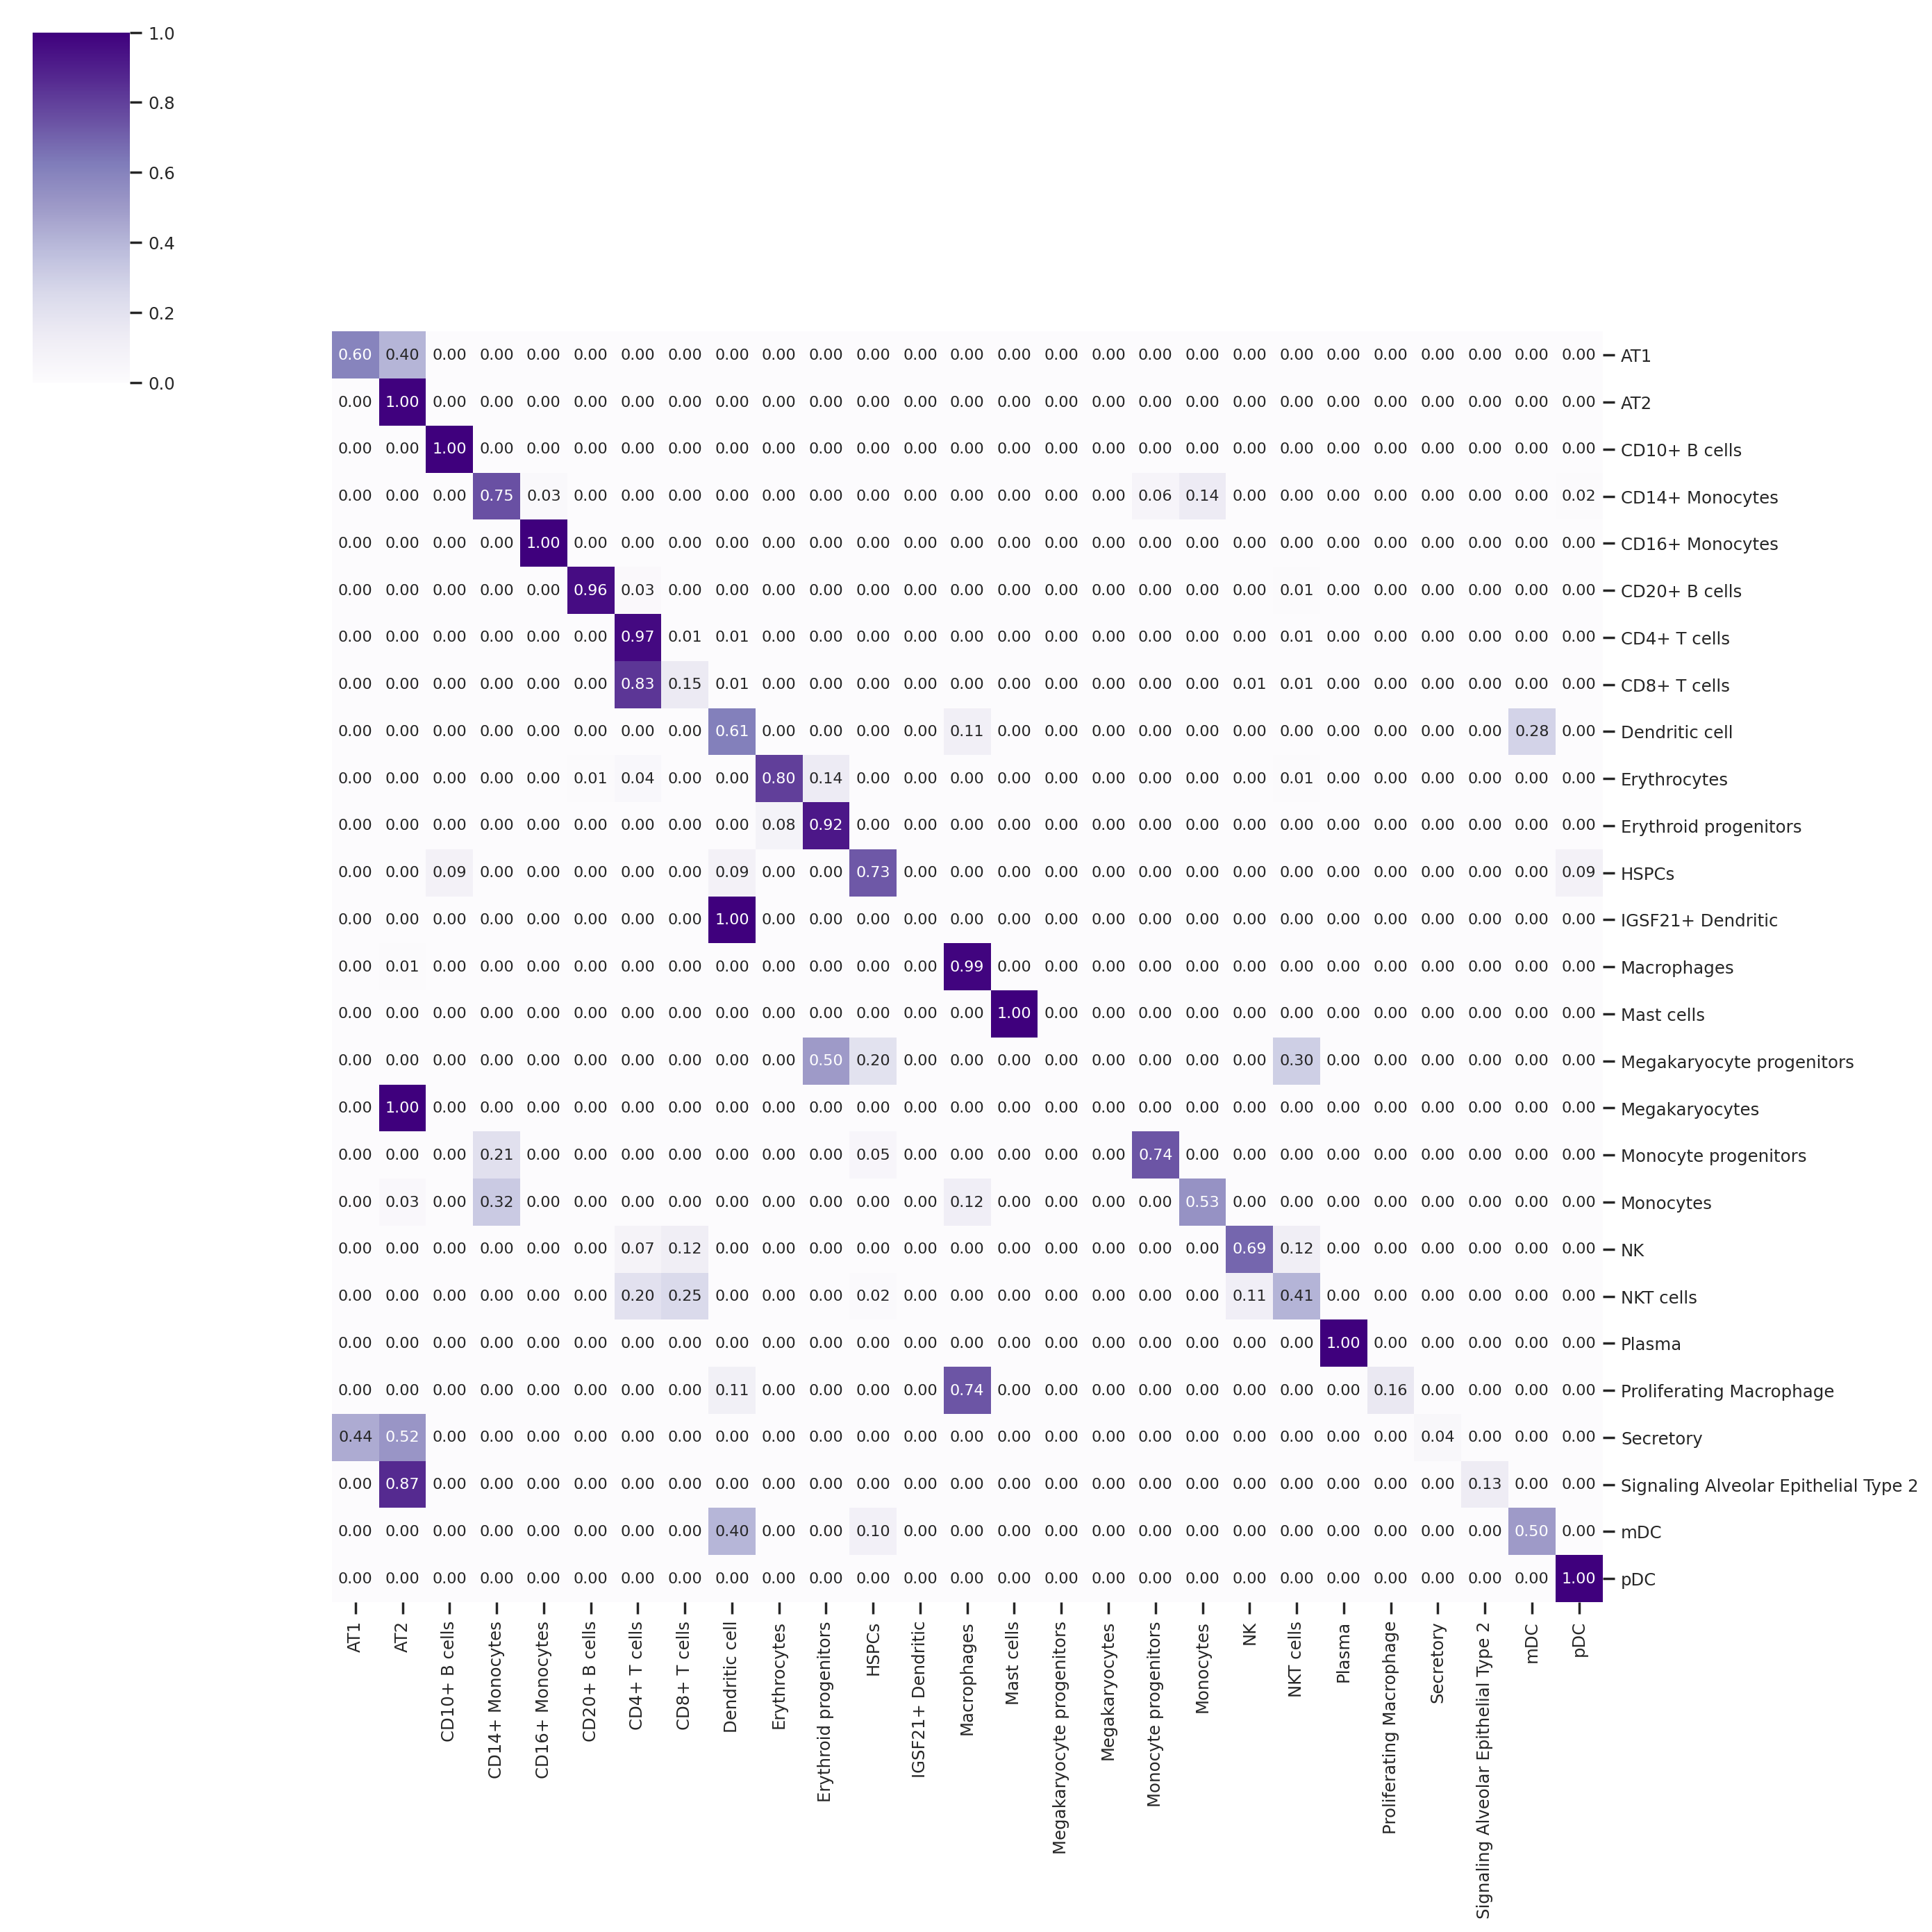

In [14]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[: matrix.shape[0]], columns=cell_type_list[: matrix.shape[1]])

ax = sns.clustermap(
    df,
    cmap="Purples",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    vmin=0,
    vmax=1,
    row_cluster=False,
    col_cluster=False,
    figsize=(14, 14),
)

## Appendix: Reference mapping on Lung-Kim dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).

In [15]:
! tree -L 3 /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/datasets
├── COVID-19-splitted
│   └── covid
│       ├── batch_covid_subsampled_test.h5ad
│       └── batch_covid_subsampled_train.h5ad
└── Lung-Kim-splitted
    └── lung
        ├── sample_proc_lung_test.h5ad
        └── sample_proc_lung_train.h5ad

5 directories, 4 files


In [16]:
adata = sc.read_h5ad(data_dir + "/Lung-Kim-splitted/lung/sample_proc_lung_train.h5ad")
test_adata = sc.read_h5ad(data_dir + "/Lung-Kim-splitted/lung/sample_proc_lung_test.h5ad")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)

gene_col = "gene_name"
cell_type_key = "cell_type"

In [17]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(ref_embed_adata)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

scGPT - INFO - match 2978/3000 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells:  99%|█████████▉| 361/363 [01:10<00:00, 16.39it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multip

scGPT - INFO - match 2978/3000 genes in vocabulary of size 60697.


/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/code/scgpt/scGPT/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 114/114 [00:10<00:00, 16.19it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/scgpt/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File 

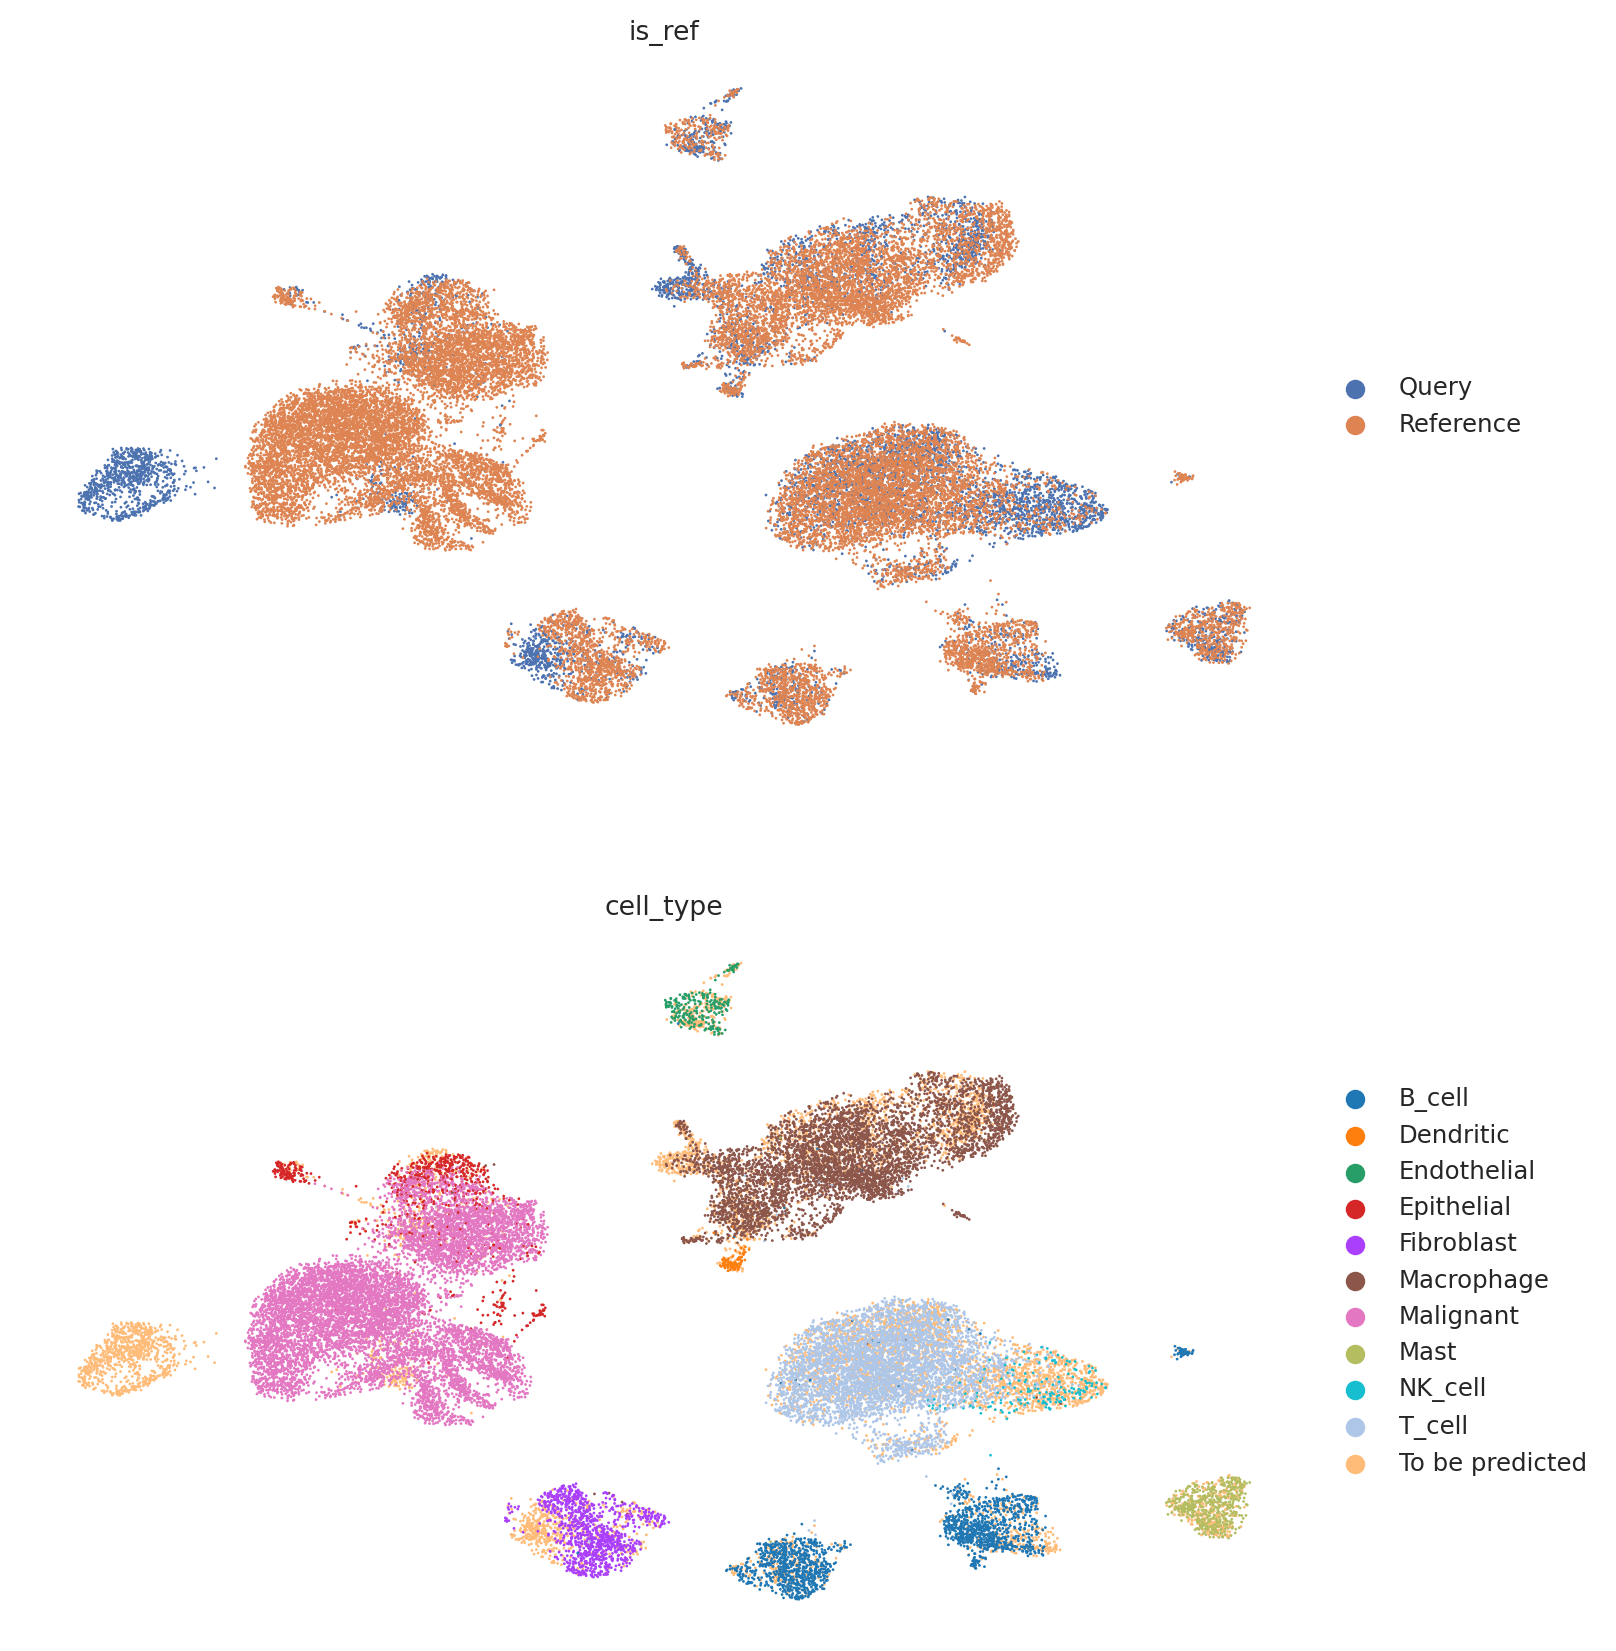

In [18]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1)

In [19]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list = [i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/2572215664.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/2572215664.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/.tmpdir/ipykernel_158636/2572215664.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer 

In [20]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.9676135583916564,
 'precision': 0.9649653291514317,
 'recall': 0.940866259444688,
 'macro_f1': 0.9511259047785432}

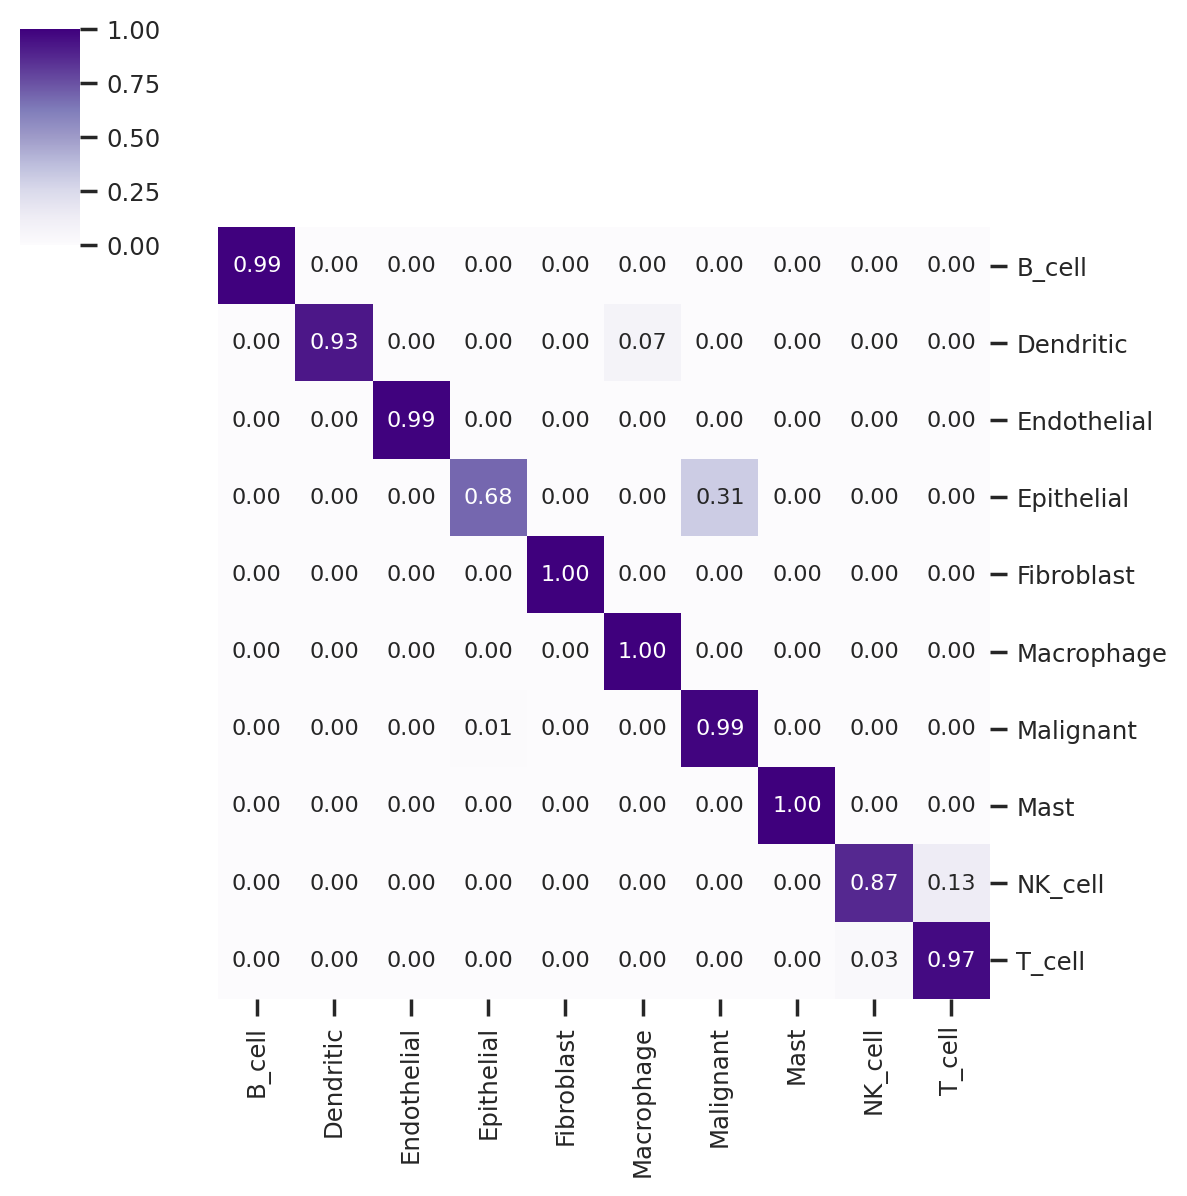

In [21]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[: matrix.shape[0]], columns=cell_type_list[: matrix.shape[1]])

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina' 

ax = sns.clustermap(
    df,
    cmap="Purples",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    vmin=0,
    vmax=1,
    row_cluster=False,
    col_cluster=False,
    figsize=(6, 6),
)